# S13: The contribution of AlphaFold models to Oncodrive3D discovery

# Experimentally obtained structure analysis
* How many genes or mutations with clusters are and are not covered by experimentally obtained structures? 
* Quantify the added value of using AlphaFold predicted structures in the prediction of driver genes and mutations

## Get a dataframe for PDB to Uniprot mapping

* Used canonical Uniprot ID
* Removed structures without resolution info (NMR): to discuss (around 1xx structures)

In [37]:
import pandas as pd
import requests
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from concurrent.futures import ThreadPoolExecutor, as_completed
import sys
import re 

sys.path.append('../../')
from global_variables import SUBDIR, RUN, WORKSPACE

In [3]:
!wget -O pdb_chain_uniprot.tsv.gz "https://ftp.ebi.ac.uk/pub/databases/msd/sifts/flatfiles/tsv/pdb_chain_uniprot.tsv.gz"
# !wget -O uniprot_pdb.tsv.gz "https://ftp.ebi.ac.uk/pub/databases/msd/sifts/flatfiles/tsv/uniprot_pdb.tsv.gz"
# !wget -O UP000000226_3885.dat.gz "https://ftp.uniprot.org/pub/databases/uniprot/current_release/knowledgebase/reference_proteomes/Eukaryota/UP000000226/UP000000226_3885.dat.gz"
# !wget -O UP000000226_3885.idmapping.gz "https://ftp.uniprot.org/pub/databases/uniprot/current_release/knowledgebase/reference_proteomes/Eukaryota/UP000000226/UP000000226_3885.idmapping.gz"

--2025-05-26 14:21:35--  https://ftp.ebi.ac.uk/pub/databases/msd/sifts/flatfiles/tsv/pdb_chain_uniprot.tsv.gz
Resolving ftp.ebi.ac.uk (ftp.ebi.ac.uk)... 193.62.193.165
Connecting to ftp.ebi.ac.uk (ftp.ebi.ac.uk)|193.62.193.165|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5550379 (5.3M) [application/x-gzip]
Saving to: ‘pdb_chain_uniprot.tsv.gz’

pdb_chain_uniprot.t 100%[===================>]   5.29M  8.91MB/s    in 0.6s    

2025-05-26 14:21:36 (8.91 MB/s) - ‘pdb_chain_uniprot.tsv.gz’ saved [5550379/5550379]



In [4]:
# Load PDB to Uniprot mapping
pdb_uniprot = pd.read_table("pdb_chain_uniprot.tsv.gz", skiprows=1)
display(pdb_uniprot)

pdb_uniprot = pdb_uniprot[pdb_uniprot["CHAIN"] == "A"]
pdb_uniprot = pdb_uniprot[["PDB", "SP_PRIMARY", "SP_BEG", "SP_END"]].rename(
    columns={"SP_PRIMARY" : "Uniprot_ID", "SP_BEG" : "Start", "SP_END": "End"}).reset_index(drop=True)
pdb_uniprot

,PDB,CHAIN,SP_PRIMARY,RES_BEG,RES_END,PDB_BEG,PDB_END,SP_BEG,SP_END
0,101m,A,P02185,1,154,0,153,1,154
1,102l,A,P00720,1,40,1,40,1,40
2,102l,A,P00720,42,165,41,None,41,164
3,102m,A,P02185,1,154,0,153,1,154
4,103l,A,P00720,1,40,1,None,1,40
...,...,...,...,...,...,...,...,...,...
892814,9xia,A,P24300,1,388,1,None,1,388
892815,9xim,A,P12851,1,393,None,394,2,394
892816,9xim,B,P12851,1,393,None,394,2,394
892817,9xim,C,P12851,1,393,None,394,2,394


,PDB,Uniprot_ID,Start,End
0,101m,P02185,1,154
1,102l,P00720,1,40
2,102l,P00720,41,164
3,102m,P02185,1,154
4,103l,P00720,1,40
...,...,...,...,...
219666,9uoa,Q72547,427,506
219667,9uoa,Q72547,518,561
219668,9wga,P02876,28,198
219669,9xia,P24300,1,388


In [38]:
print(f"{WORKSPACE}/nobackup/scratch/oncodrive3d/datasets_240506/seq_for_mut_prob.tsv")


/data/bbg/nobackup/scratch/oncodrive3d/datasets_240506/seq_for_mut_prob.tsv


In [5]:
# Get genes detected by O3D
canonical_metadata = pd.read_table(f"{WORKSPACE}/nobackup/scratch/oncodrive3d/datasets_240506/seq_for_mut_prob.tsv")
canonical_metadata = canonical_metadata[["Gene", "Uniprot_ID"]].drop_duplicates().reset_index(drop=True)

genetable = pd.read_table(f"{WORKSPACE}/projects/clustering_3d/o3d_analysys/o3d_paper/notebooks/0.genetables/results/{SUBDIR}/{RUN}.genetable.tsv")
genetable = genetable[["Gene", "CGC", "Fish", "o3d_qval"]]
genetable = genetable[genetable["o3d_qval"] < 0.01].reset_index(drop=True)
genetable = genetable[["Gene", "CGC"]].drop_duplicates()
genetable = genetable.merge(canonical_metadata, on="Gene", how="left")
genetable

,Gene,CGC,Uniprot_ID
0,PIK3CA,1,P42336
1,RXRA,0,P19793
2,FGFR3,1,P22607
3,FBXW7,1,Q969H0
4,TP53,1,P04637
...,...,...,...
268,CNBD1,1,Q8NA66
269,CDH1,1,P12830
270,TRIM49C,0,P0CI26
271,SPTA1,0,P02549


In [6]:
# Get PDB structures with covered regions mapped to genes detected by O3D
pdb_uniprot = genetable.merge(pdb_uniprot, on="Uniprot_ID", how="inner")
pdb_uniprot

,Gene,CGC,Uniprot_ID,PDB,Start,End
0,PIK3CA,1,P42336,2enq,331,481
1,PIK3CA,1,P42336,2rd0,1,1068
2,PIK3CA,1,P42336,3hhm,1,1068
3,PIK3CA,1,P42336,3hiz,1,1068
4,PIK3CA,1,P42336,3zim,107,1046
...,...,...,...,...,...,...
4730,EPAS1,1,Q99814,6x3d,239,348
4731,EPAS1,1,Q99814,7ujv,523,542
4732,EPAS1,1,Q99814,8ck3,239,350
4733,EPAS1,1,Q99814,8ck4,239,350


In [7]:
# Get resolution of PDB structures

pdb_ids = pdb_uniprot["PDB"].unique()
api_url = "https://data.rcsb.org/rest/v1/core/entry/"

def get_resolution(pdb_id, retries=2):
    for attempt in range(retries + 1): 
        try:
            response = requests.get(api_url + pdb_id, timeout=60)  
            response.raise_for_status()
            data = response.json()
            resolution = data.get("rcsb_entry_info", {}).get("resolution_combined", [None])
            return pdb_id, resolution[0] if resolution else None
        except requests.exceptions.Timeout:
            if attempt < retries:
                print(f"Timeout for {pdb_id}, retrying ({attempt+1}/{retries})...")
                continue
            else:
                print(f"Failed to retrieve {pdb_id} after {retries} retries.")
                return pdb_id, None
        except requests.exceptions.RequestException as e:
            print(f"Error fetching data for {pdb_id}: {e}")
            return pdb_id, None

resolutions = {}
with ThreadPoolExecutor(max_workers=10) as executor:  
    future_to_pdb = {executor.submit(get_resolution, pdb_id): pdb_id for pdb_id in pdb_ids}

    for future in tqdm(as_completed(future_to_pdb), total=len(pdb_ids), desc="Fetching Resolutions"):
        pdb_id, resolution = future.result()
        resolutions[pdb_id] = resolution

Fetching Resolutions:   1%|          | 45/4533 [00:19<02:27, 30.44it/s]

Timeout for 6gvh, retrying (1/2)...
Timeout for 6gvg, retrying (1/2)...
Timeout for 6gvi, retrying (1/2)...
Timeout for 6nct, retrying (1/2)...
Timeout for 7k6m, retrying (1/2)...
Timeout for 7jiu, retrying (1/2)...
Timeout for 6oac, retrying (1/2)...
Timeout for 6pys, retrying (1/2)...
Timeout for 6vo7, retrying (1/2)...
Timeout for 7k6n, retrying (1/2)...


Fetching Resolutions: 100%|██████████| 4533/4533 [04:19<00:00, 17.47it/s]


In [8]:
# Get resolution and save
pdb_uniprot["Resolution"] = pdb_uniprot.PDB.map(resolutions)
pdb_uniprot.to_csv("pdb_uniprot_o3d_predicted_drivers.tsv", sep="\t", index=False, compression="gzip")
pdb_uniprot

,Gene,CGC,Uniprot_ID,PDB,Start,End,Resolution
0,PIK3CA,1,P42336,2enq,331,481,NaN
1,PIK3CA,1,P42336,2rd0,1,1068,3.050
2,PIK3CA,1,P42336,3hhm,1,1068,2.800
3,PIK3CA,1,P42336,3hiz,1,1068,3.300
4,PIK3CA,1,P42336,3zim,107,1046,2.850
...,...,...,...,...,...,...,...
4730,EPAS1,1,Q99814,6x3d,239,348,2.000
4731,EPAS1,1,Q99814,7ujv,523,542,1.800
4732,EPAS1,1,Q99814,8ck3,239,350,1.707
4733,EPAS1,1,Q99814,8ck4,239,350,2.290


## Retrieve PDBs from Uniprot 

In [9]:
def get_start_end_pdb(value):
    
    match = re.search(r'=(\d+)-(\d+)', value)
    if match:
        start = int(match.group(1))
        end = int(match.group(2))
        return start, end
    else:
        return None, None
    

def get_numeric(value):
    
    match = re.search(r'([\d]+\.\d+)', value)
    if match:
        return float(match.group(1))
    else:
        return np.nan
    

def get_associated_pdb(uniprot_id):

    url = f"https://rest.uniprot.org/uniprotkb/{uniprot_id}.json"
    resp = requests.get(url, headers={"Accept": "application/json"})
    data = resp.json()

    seq_len = int(data["sequence"]["length"])

    lst_result = []
    for xref in data.get("uniProtKBCrossReferences", []):
        if xref["database"] == "PDB":
            pdb_id = xref["id"]
            resolution = get_numeric(xref["properties"][1]["value"])
            start, end = get_start_end_pdb(xref["properties"][2]["value"])
                    
            lst_result.append({
                "Uniprot_ID": uniprot_id, 
                "PDB": pdb_id, 
                "Start": start, 
                "End": end, 
                "Resolution": resolution,
                "Coverage": np.round((end - start + 1) / seq_len * 100, 2)
                })

    return pd.DataFrame(lst_result)

In [10]:
result = []
for uni_id in tqdm(genetable.Uniprot_ID):
    result.append(get_associated_pdb(uni_id))
pdb_uniprot_api = genetable.merge(pd.concat(result), on="Uniprot_ID", how="left")
pdb_uniprot_api = pdb_uniprot_api.dropna(subset="PDB").reset_index(drop=True)
pdb_uniprot_api

100%|██████████| 273/273 [01:11<00:00,  3.82it/s]


,Gene,CGC,Uniprot_ID,PDB,Start,End,Resolution,Coverage
0,PIK3CA,1,P42336,2ENQ,331.0,481.0,NaN,14.14
1,PIK3CA,1,P42336,2RD0,1.0,1068.0,3.05,100.00
2,PIK3CA,1,P42336,3HHM,1.0,1068.0,2.80,100.00
3,PIK3CA,1,P42336,3HIZ,1.0,1068.0,3.30,100.00
4,PIK3CA,1,P42336,3ZIM,107.0,1046.0,2.85,88.01
...,...,...,...,...,...,...,...,...
6216,EPAS1,1,Q99814,8CK8,239.0,350.0,2.30,12.87
6217,EPAS1,1,Q99814,8Q5S,523.0,542.0,1.49,2.30
6218,EPAS1,1,Q99814,8Q64,523.0,542.0,1.36,2.30
6219,EPAS1,1,Q99814,8Q6D,523.0,542.0,1.40,2.30


## How many genes detected have a solved structure?
### Unique genes

__Resolution:__
* <1.5 Å → Excellent, near atomic-level precision.
* 1.5–2.5 Å → Good, sufficient for reliable side-chain modeling.
* 2.5–3.5 Å → Moderate, backbone is reliable, but some side chains may be ambiguous.
* \>3.5 Å → Low.

In [11]:
def report_genes_in_pdb(pdb_uniprot, genetable):
        
    genes_in_pdb = pdb_uniprot[["Gene", "CGC", "Uniprot_ID"]].drop_duplicates()
    print(f"Total: {len(genes_in_pdb)} on {len(genetable)} ({len(genes_in_pdb) / len(genetable) * 100:.2f}%)")
    
    for cgc in [1, 0]:
        genetable_cgc = genetable[genetable["CGC"] == cgc]
        genes_in_pdb_cgc = genes_in_pdb[genes_in_pdb['CGC'] == cgc]
        print(f"CGC {cgc}: {len(genes_in_pdb_cgc)} on {len(genetable_cgc)} ({len(genes_in_pdb_cgc) / len(genetable_cgc) * 100:.2f}%)")


def get_gene_in_pdb(pdb_uniprot, genetable):

    genes_in_pdb = pdb_uniprot[["Gene", "CGC", "Uniprot_ID"]].drop_duplicates()   
     
    # All
    total_genes = len(genetable)
    total_in_pdb = len(genes_in_pdb)
    
    # CGC 
    cgc = 1
    genetable_cgc = genetable[genetable["CGC"] == cgc]
    genes_in_pdb_cgc = genes_in_pdb[genes_in_pdb['CGC'] == cgc]

    total_cgc1 = len(genetable_cgc)
    cgc1_in_pdb = len(genes_in_pdb_cgc)
    
    # Not CGC
    cgc = 0
    genetable_cgc = genetable[genetable["CGC"] == cgc]
    genes_in_pdb_cgc = genes_in_pdb[genes_in_pdb['CGC'] == cgc]

    total_cgc0 = len(genetable_cgc)
    cgc0_in_pdb = len(genes_in_pdb_cgc)

    result = {}
    result["Total"] = total_genes, total_cgc1, total_cgc0
    result["In_pdb"] = {"All": total_in_pdb, "CGC": cgc1_in_pdb, "Not CGC": cgc0_in_pdb}

    return result


def add_percent_labels(bars, df_in, df_not, column, offset = 3):
    for bar, category in zip(bars, categories):
        total = df_in[column][category] + df_not[column][category]
        if total > 0:
            pct = (1 - (df_in[column][category] / total)) * 100
            x = bar.get_x() + bar.get_width() / 2 + 0.006
            y = total + offset
            ax.text(x, y, f"{pct:.1f}%", ha='center', fontsize=10)

def add_segment_counts(bars, df_segment, df_other, column, offset = 3):
    """
    bars:   the BarContainer for either the bottom or top segments
    df_segment:  df_in_pdb (for bottom) or df_not_in_pdb (for top)
    df_other:    the other df, so we can compute the total
    """
    for bar, category in zip(bars, categories):
        count = df_segment[column][category]
        total = df_segment[column][category] + df_other[column][category]
        y_top = bar.get_y() + bar.get_height()
        y = y_top - offset
        y = 10 if y < 10 else y
        x = bar.get_x() + bar.get_width()/2
        ax.text(x, y, f"{count}", ha='center', va='top', fontsize=10)

### From Uniprot API

In [12]:
print("Detected genes in solved structures:\n")
print("> Any quality:")
report_genes_in_pdb(pdb_uniprot_api, genetable)

print("\n> Å < 3.5:")
report_genes_in_pdb(pdb_uniprot_api[pdb_uniprot_api["Resolution"] < 3.5], genetable)

print("\n> Å < 2.5:")
report_genes_in_pdb(pdb_uniprot_api[pdb_uniprot_api["Resolution"] < 2.5], genetable)

print("\n> Å < 1.5:")
report_genes_in_pdb(pdb_uniprot_api[pdb_uniprot_api["Resolution"] < 1.5], genetable)

Detected genes in solved structures:

> Any quality:
Total: 165 on 273 (60.44%)
CGC 1: 99 on 106 (93.40%)
CGC 0: 66 on 167 (39.52%)

> Å < 3.5:
Total: 155 on 273 (56.78%)
CGC 1: 95 on 106 (89.62%)
CGC 0: 60 on 167 (35.93%)

> Å < 2.5:
Total: 127 on 273 (46.52%)
CGC 1: 83 on 106 (78.30%)
CGC 0: 44 on 167 (26.35%)

> Å < 1.5:
Total: 42 on 273 (15.38%)
CGC 1: 32 on 106 (30.19%)
CGC 0: 10 on 167 (5.99%)


In [13]:
pdb_uniprot_api_thr = pdb_uniprot_api[pdb_uniprot_api["Coverage"] > 50].reset_index(drop=True)
pdb_uniprot_api_thr

,Gene,CGC,Uniprot_ID,PDB,Start,End,Resolution,Coverage
0,PIK3CA,1,P42336,2RD0,1.0,1068.0,3.05,100.00
1,PIK3CA,1,P42336,3HHM,1.0,1068.0,2.80,100.00
2,PIK3CA,1,P42336,3HIZ,1.0,1068.0,3.30,100.00
3,PIK3CA,1,P42336,3ZIM,107.0,1046.0,2.85,88.01
4,PIK3CA,1,P42336,4JPS,1.0,1068.0,2.20,100.00
...,...,...,...,...,...,...,...,...
3202,RHOA,1,P61586,8GI3,1.0,193.0,1.52,100.00
3203,RHOA,1,P61586,8GI6,1.0,193.0,1.40,100.00
3204,RHOA,1,P61586,8JVJ,1.0,193.0,3.44,100.00
3205,RHOA,1,P61586,8T1C,1.0,193.0,3.49,100.00


In [14]:
# Detected genes at different PDB quality thresholds and total number
result = {}
for resolution in ["Any", 3.5, 2.5, 1.5]: 
    df = pdb_uniprot_api_thr[pdb_uniprot_api_thr["Resolution"] < resolution] if isinstance(resolution, float) else pdb_uniprot_api_thr
    name = f"Å < {resolution}" if isinstance(resolution, float) else "Any Quality"
    result[name] = get_gene_in_pdb(df, genetable)
    
total_genes, cgc1_total, cgc0_total = result["Any Quality"]["Total"]
in_pdb_genes = {k: result[k]["In_pdb"] for k in result.keys()}


# Compute not detected genes
not_pdb_genes = {
    quality: {
        "All": total_genes - values["All"],
        "CGC": cgc1_total - values["CGC"],
        "Not CGC": cgc0_total - values["Not CGC"],
    }
    for quality, values in in_pdb_genes.items()
}

# Convert to DataFrame for easier handling
df_in_pdb = pd.DataFrame(in_pdb_genes).T
df_not_in_pdb = pd.DataFrame(not_pdb_genes).T

display(df_in_pdb)
display(df_not_in_pdb)

,All,CGC,Not CGC
Any Quality,94,63,31
Å < 3.5,88,60,28
Å < 2.5,42,30,12
Å < 1.5,12,12,0


,All,CGC,Not CGC
Any Quality,179,43,136
Å < 3.5,185,46,139
Å < 2.5,231,76,155
Å < 1.5,261,94,167


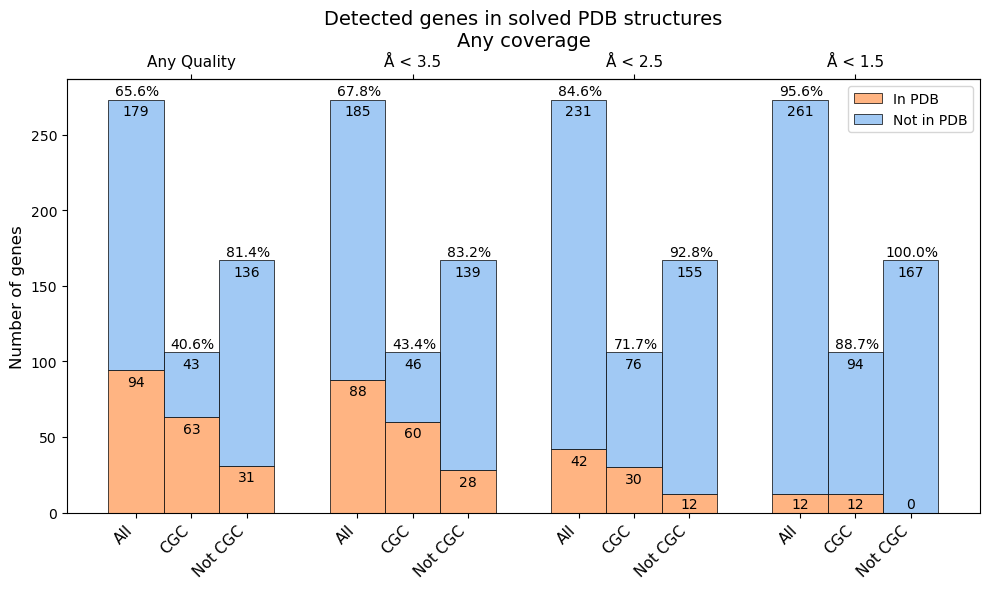

In [15]:
# Plot

categories = ["Any Quality", "Å < 3.5", "Å < 2.5", "Å < 1.5"]

x = np.arange(len(categories))
width = 0.25
color_in_pdb = "#FFB482" 
color_not_in_pdb = "#A1C9F4"

fig, ax = plt.subplots(figsize=(10, 6))

# Plot the three stacks
bars_in_all = ax.bar(x - width, df_in_pdb["All"], width,
                        label="In PDB", color=color_in_pdb, lw=0.5, ec="black")
bars_not_all = ax.bar(x - width, df_not_in_pdb["All"], width,
                        label="Not in PDB", bottom=df_in_pdb["All"], color=color_not_in_pdb, lw=0.5, ec="black")
add_percent_labels(bars_in_all, df_in_pdb, df_not_in_pdb, "All")
add_segment_counts(bars_in_all, df_in_pdb, df_not_in_pdb, "All")
add_segment_counts(bars_not_all, df_not_in_pdb, df_in_pdb, "All")

bars_in_cgc = ax.bar(x, df_in_pdb["CGC"], width,
                        color=color_in_pdb, lw=0.5, ec="black")
bars_not_cgc = ax.bar(x, df_not_in_pdb["CGC"], width,
                        bottom=df_in_pdb["CGC"], color=color_not_in_pdb, lw=0.5, ec="black")
add_percent_labels(bars_in_cgc, df_in_pdb, df_not_in_pdb, "CGC")
add_segment_counts(bars_in_cgc, df_in_pdb, df_not_in_pdb, "CGC")
add_segment_counts(bars_not_cgc, df_not_in_pdb, df_in_pdb, "CGC")

bars_in_not_cgc  = ax.bar(x + width, df_in_pdb["Not CGC"], width,
                          color=color_in_pdb, lw=0.5, ec="black")
bars_not_not_cgc = ax.bar(x + width, df_not_in_pdb["Not CGC"], width,
                          bottom=df_in_pdb["Not CGC"], color=color_not_in_pdb, lw=0.5, ec="black")
add_percent_labels(bars_in_not_cgc, df_in_pdb, df_not_in_pdb, "Not CGC")
add_segment_counts(bars_in_not_cgc, df_in_pdb, df_not_in_pdb, "Not CGC")
add_segment_counts(bars_not_not_cgc, df_not_in_pdb, df_in_pdb, "Not CGC")

# Details
ax.set_xticks(np.concatenate([x-width, x, x+width]))
ax.set_xticklabels(
    ["All"] * len(categories) + ["CGC"] * len(categories) + ["Not CGC"] * len(categories),
    rotation=45, ha='right', fontsize=11
)
ax.set_ylabel("Number of genes", fontsize=12)
ax.set_title("Detected genes in solved PDB structures\nAny coverage", fontsize=14)

ax2 = ax.secondary_xaxis("top")
ax2.set_xticks(x)
ax2.set_xticklabels(categories, fontsize=11)

ax.legend(loc="upper right")
plt.tight_layout()
plt.show()

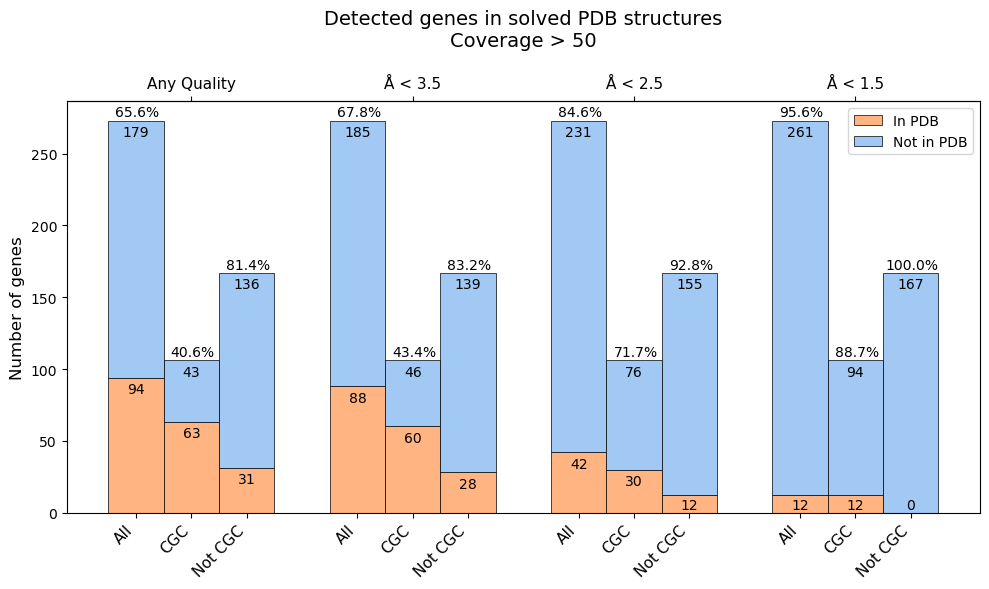

In [16]:
# Plot

categories = ["Any Quality", "Å < 3.5", "Å < 2.5", "Å < 1.5"]

x = np.arange(len(categories))
width = 0.25
color_in_pdb = "#FFB482" 
color_not_in_pdb = "#A1C9F4"

fig, ax = plt.subplots(figsize=(10, 6))

# Plot the three stacks
bars_in_all = ax.bar(x - width, df_in_pdb["All"], width,
                        label="In PDB", color=color_in_pdb, lw=0.5, ec="black")
bars_not_all = ax.bar(x - width, df_not_in_pdb["All"], width,
                        label="Not in PDB", bottom=df_in_pdb["All"], color=color_not_in_pdb, lw=0.5, ec="black")
add_percent_labels(bars_in_all, df_in_pdb, df_not_in_pdb, "All")
add_segment_counts(bars_in_all, df_in_pdb, df_not_in_pdb, "All")
add_segment_counts(bars_not_all, df_not_in_pdb, df_in_pdb, "All")

bars_in_cgc = ax.bar(x, df_in_pdb["CGC"], width,
                        color=color_in_pdb, lw=0.5, ec="black")
bars_not_cgc = ax.bar(x, df_not_in_pdb["CGC"], width,
                        bottom=df_in_pdb["CGC"], color=color_not_in_pdb, lw=0.5, ec="black")
add_percent_labels(bars_in_cgc, df_in_pdb, df_not_in_pdb, "CGC")
add_segment_counts(bars_in_cgc, df_in_pdb, df_not_in_pdb, "CGC")
add_segment_counts(bars_not_cgc, df_not_in_pdb, df_in_pdb, "CGC")

bars_in_not_cgc  = ax.bar(x + width, df_in_pdb["Not CGC"], width,
                          color=color_in_pdb, lw=0.5, ec="black")
bars_not_not_cgc = ax.bar(x + width, df_not_in_pdb["Not CGC"], width,
                          bottom=df_in_pdb["Not CGC"], color=color_not_in_pdb, lw=0.5, ec="black")
add_percent_labels(bars_in_not_cgc, df_in_pdb, df_not_in_pdb, "Not CGC")
add_segment_counts(bars_in_not_cgc, df_in_pdb, df_not_in_pdb, "Not CGC")
add_segment_counts(bars_not_not_cgc, df_not_in_pdb, df_in_pdb, "Not CGC")

# Details
ax.set_xticks(np.concatenate([x-width, x, x+width]))
ax.set_xticklabels(
    ["All"] * len(categories) + ["CGC"] * len(categories) + ["Not CGC"] * len(categories),
    rotation=45, ha='right', fontsize=11
)
ax.set_ylabel("Number of genes", fontsize=12)
ax.set_title("Detected genes in solved PDB structures\nCoverage > 50\n", fontsize=14)

ax2 = ax.secondary_xaxis("top")
ax2.set_xticks(x)
ax2.set_xticklabels(categories, fontsize=11)

ax.legend(loc="upper right")
plt.tight_layout()
plt.show()

### From SIFTS

In [17]:
print("Detected genes in solved structures:\n")
print("> Any quality:")
report_genes_in_pdb(pdb_uniprot, genetable)

print("\n> Å < 3.5:")
report_genes_in_pdb(pdb_uniprot[pdb_uniprot["Resolution"] < 3.5], genetable)

print("\n> Å < 2.5:")
report_genes_in_pdb(pdb_uniprot[pdb_uniprot["Resolution"] < 2.5], genetable)

print("\n> Å < 1.5:")
report_genes_in_pdb(pdb_uniprot[pdb_uniprot["Resolution"] < 1.5], genetable)

Detected genes in solved structures:

> Any quality:
Total: 144 on 273 (52.75%)
CGC 1: 92 on 106 (86.79%)
CGC 0: 52 on 167 (31.14%)

> Å < 3.5:
Total: 133 on 273 (48.72%)
CGC 1: 87 on 106 (82.08%)
CGC 0: 46 on 167 (27.54%)

> Å < 2.5:
Total: 111 on 273 (40.66%)
CGC 1: 76 on 106 (71.70%)
CGC 0: 35 on 167 (20.96%)

> Å < 1.5:
Total: 31 on 273 (11.36%)
CGC 1: 26 on 106 (24.53%)
CGC 0: 5 on 167 (2.99%)


In [18]:
# Detected genes at different PDB quality thresholds and total number
result = {}
for resolution in ["Any", 3.5, 2.5, 1.5]: 
    df = pdb_uniprot[pdb_uniprot["Resolution"] < resolution] if isinstance(resolution, float) else pdb_uniprot
    name = f"Å < {resolution}" if isinstance(resolution, float) else "Any Quality"
    result[name] = get_gene_in_pdb(df, genetable)
    
total_genes, cgc1_total, cgc0_total = result["Any Quality"]["Total"]
in_pdb_genes = {k: result[k]["In_pdb"] for k in result.keys()}


# Compute not detected genes
not_pdb_genes = {
    quality: {
        "All": total_genes - values["All"],
        "CGC": cgc1_total - values["CGC"],
        "Not CGC": cgc0_total - values["Not CGC"],
    }
    for quality, values in in_pdb_genes.items()
}

# Convert to DataFrame for easier handling
df_in_pdb = pd.DataFrame(in_pdb_genes).T
df_not_in_pdb = pd.DataFrame(not_pdb_genes).T

display(df_in_pdb)
display(df_not_in_pdb)

,All,CGC,Not CGC
Any Quality,144,92,52
Å < 3.5,133,87,46
Å < 2.5,111,76,35
Å < 1.5,31,26,5


,All,CGC,Not CGC
Any Quality,129,14,115
Å < 3.5,140,19,121
Å < 2.5,162,30,132
Å < 1.5,242,80,162


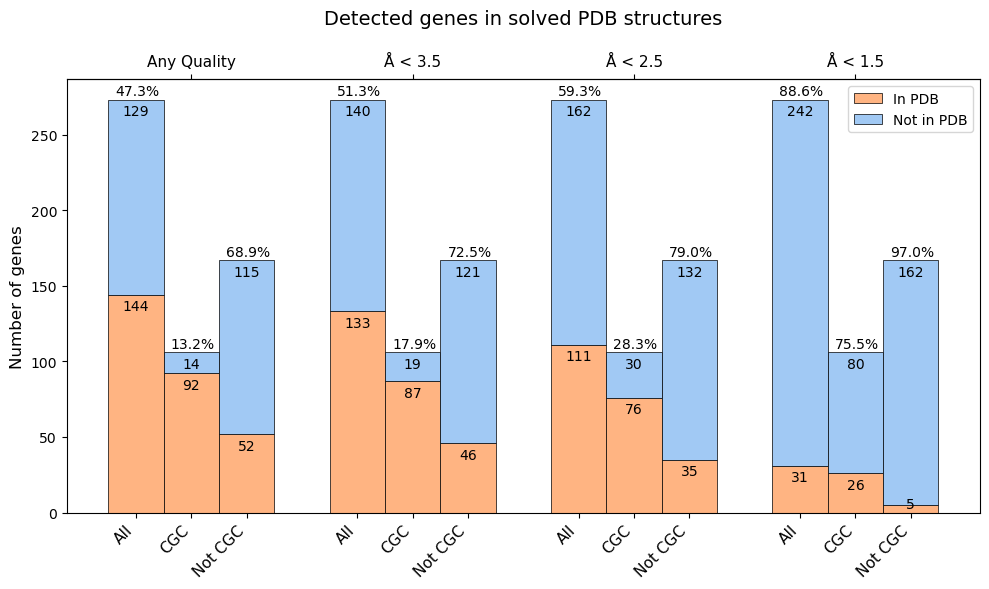

In [19]:
# Plot

categories = ["Any Quality", "Å < 3.5", "Å < 2.5", "Å < 1.5"]

x = np.arange(len(categories))
width = 0.25
color_in_pdb = "#FFB482" 
color_not_in_pdb = "#A1C9F4"

fig, ax = plt.subplots(figsize=(10, 6))

# Plot the three stacks
bars_in_all = ax.bar(x - width, df_in_pdb["All"], width,
                        label="In PDB", color=color_in_pdb, lw=0.5, ec="black")
bars_not_all = ax.bar(x - width, df_not_in_pdb["All"], width,
                        label="Not in PDB", bottom=df_in_pdb["All"], color=color_not_in_pdb, lw=0.5, ec="black")
add_percent_labels(bars_in_all, df_in_pdb, df_not_in_pdb, "All")
add_segment_counts(bars_in_all, df_in_pdb, df_not_in_pdb, "All")
add_segment_counts(bars_not_all, df_not_in_pdb, df_in_pdb, "All")

bars_in_cgc = ax.bar(x, df_in_pdb["CGC"], width,
                        color=color_in_pdb, lw=0.5, ec="black")
bars_not_cgc = ax.bar(x, df_not_in_pdb["CGC"], width,
                        bottom=df_in_pdb["CGC"], color=color_not_in_pdb, lw=0.5, ec="black")
add_percent_labels(bars_in_cgc, df_in_pdb, df_not_in_pdb, "CGC")
add_segment_counts(bars_in_cgc, df_in_pdb, df_not_in_pdb, "CGC")
add_segment_counts(bars_not_cgc, df_not_in_pdb, df_in_pdb, "CGC")

bars_in_not_cgc  = ax.bar(x + width, df_in_pdb["Not CGC"], width,
                          color=color_in_pdb, lw=0.5, ec="black")
bars_not_not_cgc = ax.bar(x + width, df_not_in_pdb["Not CGC"], width,
                          bottom=df_in_pdb["Not CGC"], color=color_not_in_pdb, lw=0.5, ec="black")
add_percent_labels(bars_in_not_cgc, df_in_pdb, df_not_in_pdb, "Not CGC")
add_segment_counts(bars_in_not_cgc, df_in_pdb, df_not_in_pdb, "Not CGC")
add_segment_counts(bars_not_not_cgc, df_not_in_pdb, df_in_pdb, "Not CGC")

# Details
ax.set_xticks(np.concatenate([x-width, x, x+width]))
ax.set_xticklabels(
    ["All"] * len(categories) + ["CGC"] * len(categories) + ["Not CGC"] * len(categories),
    rotation=45, ha='right', fontsize=11
)
ax.set_ylabel("Number of genes", fontsize=12)
ax.set_title("Detected genes in solved PDB structures\n", fontsize=14)

ax2 = ax.secondary_xaxis("top")
ax2.set_xticks(x)
ax2.set_xticklabels(categories, fontsize=11)

ax.legend(loc="upper right")
plt.tight_layout()
plt.show()

### Gene-cohort

In [20]:
genetable_all = pd.read_table(f"{WORKSPACE}/projects/clustering_3d/o3d_analysys/o3d_paper/notebooks/0.genetables/results/{SUBDIR}/{RUN}.genetable.tsv")
genetable_all = genetable_all[["Gene", "CGC", "Fish", "o3d_qval", "Cohort"]]
genetable_all = genetable_all[genetable_all["o3d_qval"] < 0.01].reset_index(drop=True)
genetable_all = genetable_all.merge(canonical_metadata, on="Gene", how="left")
genetable_all

,Gene,CGC,Fish,o3d_qval,Cohort,Uniprot_ID
0,PIK3CA,1,0,0.0,HARTWIG_WGS_BLCA_2023,P42336
1,RXRA,0,0,0.0,HARTWIG_WGS_BLCA_2023,P19793
2,FGFR3,1,0,0.0,HARTWIG_WGS_BLCA_2023,P22607
3,FBXW7,1,0,0.0,HARTWIG_WGS_BLCA_2023,Q969H0
4,TP53,1,0,0.0,HARTWIG_WGS_BLCA_2023,P04637
...,...,...,...,...,...,...
614,MED12,1,0,0.0,TCGA_WXS_PRAD,Q93074
615,CTNNB1,1,0,0.0,TCGA_WXS_PRAD,P35222
616,TP53,1,0,0.0,TCGA_WXS_SOFT_TISSUE,P04637
617,HRAS,1,0,0.0,TCGA_WXS_PGNG,P01112


In [21]:
pdb_uniprot_all = genetable_all.merge(pdb_uniprot[["Uniprot_ID", "PDB", "Start", "End", "Resolution"]], on="Uniprot_ID", how="inner")
pdb_uniprot_all = pdb_uniprot_all[["Gene", "CGC", "Cohort", "Uniprot_ID"]].drop_duplicates()
pdb_uniprot_all

,Gene,CGC,Cohort,Uniprot_ID
0,PIK3CA,1,HARTWIG_WGS_BLCA_2023,P42336
110,PIK3CA,1,HARTWIG_WGS_UCEC_2023,P42336
220,PIK3CA,1,HARTWIG_WGS_COADREAD_2023,P42336
330,PIK3CA,1,CBIOP_WXS_BRCA_MBCP_PRY_NOTREAT_2020,P42336
440,PIK3CA,1,CBIOP_WXS_BRCA_MBCP_MET_TREAT_2020,P42336
...,...,...,...,...
41337,GTF2I,0,TCGA_WXS_THYM,P78347
41341,RHOA,1,TCGA_WXS_STAD,P61586
41431,CDH1,1,TCGA_WXS_STAD,P12830
41438,SPTA1,0,TCGA_WXS_STAD,P02549


In [22]:
print("> Oncodrive3D gene-cohort detected:", len(genetable_all))
display(genetable_all.value_counts("CGC"))
print("> Oncodrive3D gene-cohort detected with available PDB structure:", len(pdb_uniprot_all))
display(pdb_uniprot_all.value_counts("CGC"))

> Oncodrive3D gene-cohort detected: 619


CGC
1    429
0    190
dtype: int64

> Oncodrive3D gene-cohort detected with available PDB structure: 459


CGC
1    397
0     62
dtype: int64

## How many clusters in detected genes are in solved structures?

In [23]:
datasets = f"{WORKSPACE}/projects/clustering_3d/o3d_analysys/datasets/"
o3d_output_dir = f"{datasets}/output/cancer_202404/o3d_output/{SUBDIR}/{RUN}"

In [24]:
# Get all clusters in O3D detected genes

def get_o3d_clusters(genetable_df, o3d_output_dir):
    
    lst_cohort = []
    for cohort in genetable_df.Cohort.unique():
        cohort = "TCGA_WXS_SOFT_TISSUE" if cohort == "TCGA_WXS_SARC" else cohort
        df_cohort = pd.read_csv(f"{o3d_output_dir}/{cohort}/{cohort}.3d_clustering_pos.csv")
        df_cohort = df_cohort[df_cohort["pval"] < 0.01]
        df_cohort = df_cohort[["Gene", "Uniprot_ID", "F", "Pos", "Score_obs_sim", "pLDDT_res", "Cohort"]]
        df_cohort = df_cohort.rename(columns={"Score_obs_sim" : "Clustering_score"})
        lst_cohort.append(df_cohort)

    df = pd.concat(lst_cohort).reset_index(drop=True)
    df = df.merge(genetable_df[["Gene", "CGC"]].drop_duplicates(), on=["Gene"], how="inner")
    df["CGC"] = df["CGC"].fillna(0)
    
    return df

o3d_clusters = get_o3d_clusters(genetable_all, o3d_output_dir)
o3d_clusters = o3d_clusters[["Gene", "Uniprot_ID", "Pos", "pLDDT_res", "CGC"]].drop_duplicates()
o3d_clusters = o3d_clusters.sort_values(["Gene", "Pos"]).reset_index(drop=True)
display(o3d_clusters.Gene.value_counts()[:10])
o3d_clusters

/tmp/ipykernel_3188128/3492789653.py:8: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df_cohort = pd.read_csv(f"{o3d_output_dir}/{cohort}/{cohort}.3d_clustering_pos.csv")


TP53      116
PTEN       46
IGLL5      36
PIK3CA     32
EGFR       31
VHL        27
CIC        23
FBXW7      22
SPOP       21
CHD4       21
Name: Gene, dtype: int64

,Gene,Uniprot_ID,Pos,pLDDT_res,CGC
0,ACVR1,D3DPA4,328,81.12,1
1,ADGRV1,Q8WXG9,4500,91.53,0
2,ADGRV1,Q8WXG9,4501,93.41,0
3,ADGRV1,Q8WXG9,4503,92.78,0
4,ADGRV1,Q8WXG9,4504,92.31,0
...,...,...,...,...,...
1373,ZNF83,P51522,290,96.00,0
1374,ZNF83,P51522,293,91.85,0
1375,ZNF880,Q6PDB4,406,89.35,0
1376,ZNF91,Q05481,353,81.18,0


In [25]:
# Report how many clusters have a solved structure

def get_cluster_in_pdb(o3d_clusters, pdb_uniprot):
    
    result = []
    for gene in o3d_clusters.Gene.unique():
        o3d_clusters_gene = o3d_clusters[o3d_clusters["Gene"] == gene]
        pdb_uniprot_gene = pdb_uniprot[pdb_uniprot["Gene"] == gene]
        o3d_clusters_gene = o3d_clusters_gene.copy()
        o3d_clusters_gene["In_PDB"] = o3d_clusters_gene["Pos"].apply(lambda pos: any((pos >= start and pos <= end) for start, end in zip(pdb_uniprot_gene["Start"], pdb_uniprot_gene["End"])))
        result.append(o3d_clusters_gene)
        
    o3d_clusters = pd.concat(result)
    o3d_clusters["In_PDB"] = o3d_clusters["In_PDB"].astype(int)
    
    return o3d_clusters


def report_cluster_in_pdb(o3d_clusters):

    cluster_in_pdb = o3d_clusters[o3d_clusters['In_PDB'] == 1]
    print(f"Total: {len(cluster_in_pdb)} on {len(o3d_clusters)} ({len(cluster_in_pdb) / len(o3d_clusters) * 100:.2f}%)")
    for cgc in [1, 0]:
        o3d_clusters_cgc = o3d_clusters[o3d_clusters["CGC"] == cgc]
        cluster_in_pdb = o3d_clusters_cgc[o3d_clusters_cgc['In_PDB'] == 1]
        print(f"CGC {cgc}: {len(cluster_in_pdb)} on {len(o3d_clusters_cgc)} ({len(cluster_in_pdb) / len(o3d_clusters_cgc) * 100:.2f}%)")
        

print("Clusters in solved structures:\n")
print("> Any quality:")
report_cluster_in_pdb(get_cluster_in_pdb(o3d_clusters, pdb_uniprot))

print("\n> Å < 3.5:")
report_cluster_in_pdb(get_cluster_in_pdb(o3d_clusters, pdb_uniprot[pdb_uniprot["Resolution"] < 3.5]))

print("\n> Å < 2.5:")
report_cluster_in_pdb(get_cluster_in_pdb(o3d_clusters, pdb_uniprot[pdb_uniprot["Resolution"] < 2.5]))

print("\n> Å < 1.5:")
report_cluster_in_pdb(get_cluster_in_pdb(o3d_clusters, pdb_uniprot[pdb_uniprot["Resolution"] < 1.5]))

Clusters in solved structures:

> Any quality:
Total: 748 on 1378 (54.28%)
CGC 1: 673 on 914 (73.63%)
CGC 0: 75 on 464 (16.16%)

> Å < 3.5:
Total: 706 on 1378 (51.23%)
CGC 1: 636 on 914 (69.58%)
CGC 0: 70 on 464 (15.09%)

> Å < 2.5:
Total: 610 on 1378 (44.27%)
CGC 1: 573 on 914 (62.69%)
CGC 0: 37 on 464 (7.97%)

> Å < 1.5:
Total: 242 on 1378 (17.56%)
CGC 1: 242 on 914 (26.48%)
CGC 0: 0 on 464 (0.00%)


In [26]:
# Define the total number of genes in each category
total_genes = 1378
cgc1_total = 914
cgc0_total = 464

# Define the detected genes at different PDB quality thresholds
in_pdb_genes = {
    "Any Quality": {"All": 748, "CGC": 673, "Not CGC": 75},
    "Å < 3.5": {"All": 706, "CGC": 636, "Not CGC": 70},
    "Å < 2.5": {"All": 610, "CGC": 573, "Not CGC": 37},
    "Å < 1.5": {"All": 242, "CGC": 242, "Not CGC": 0},
}

# Compute not detected genes
not_pdb_genes = {
    quality: {
        "All": total_genes - values["All"],
        "CGC": cgc1_total - values["CGC"],
        "Not CGC": cgc0_total - values["Not CGC"],
    }
    for quality, values in in_pdb_genes.items()
}

# Convert to DataFrame for easier handling
df_in_pdb = pd.DataFrame(in_pdb_genes).T
df_not_in_pdb = pd.DataFrame(not_pdb_genes).T

display(df_in_pdb)
display(df_not_in_pdb)

,All,CGC,Not CGC
Any Quality,748,673,75
Å < 3.5,706,636,70
Å < 2.5,610,573,37
Å < 1.5,242,242,0


,All,CGC,Not CGC
Any Quality,630,241,389
Å < 3.5,672,278,394
Å < 2.5,768,341,427
Å < 1.5,1136,672,464


In [27]:
def add_percent_labels(bars, df_in, df_not, column, offset = 15):
    for bar, category in zip(bars, categories):
        total = df_in[column][category] + df_not[column][category]
        if total > 0:
            pct = df_in[column][category] / total * 100
            x = bar.get_x() + bar.get_width() / 2 + 0.006
            y = total + offset
            ax.text(x, y, f"{pct:.1f}%", ha='center', fontsize=10)

def add_segment_counts(bars, df_segment, df_other, column, offset = 15):
    """
    bars:   the BarContainer for either the bottom or top segments
    df_segment:  df_in_pdb (for bottom) or df_not_in_pdb (for top)
    df_other:    the other df, so we can compute the total
    """
    for bar, category in zip(bars, categories):
        count = df_segment[column][category]
        total = df_segment[column][category] + df_other[column][category]
        y_top = bar.get_y() + bar.get_height()
        y = y_top - offset
        y = 40 if y < 40 else y
        x = bar.get_x() + bar.get_width()/2
        ax.text(x, y, f"{count}", ha='center', va='top', fontsize=10)

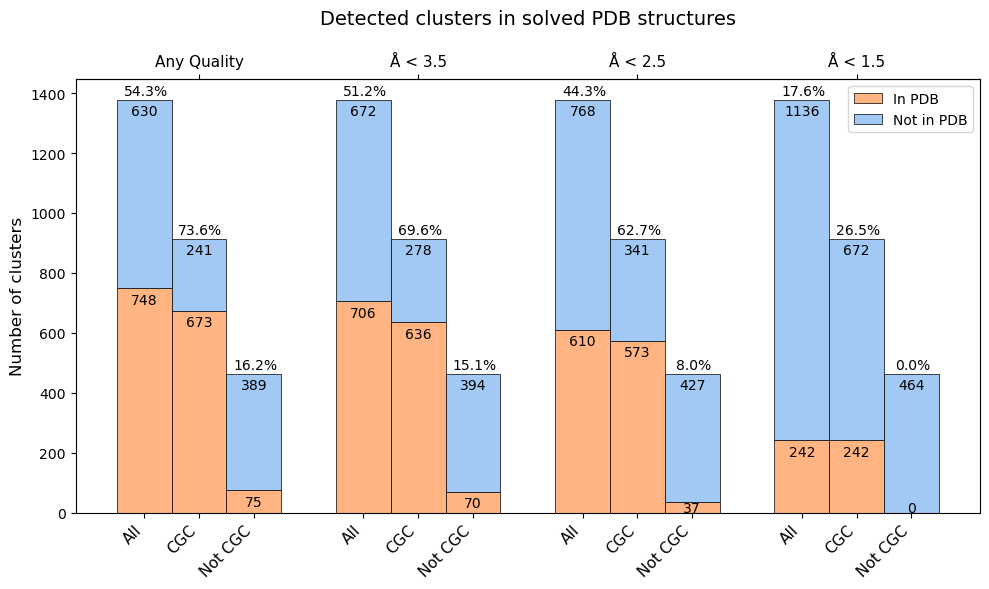

In [28]:
# Plot

categories = ["Any Quality", "Å < 3.5", "Å < 2.5", "Å < 1.5"]

x = np.arange(len(categories))
width = 0.25
color_in_pdb = "#FFB482" 
color_not_in_pdb = "#A1C9F4"

fig, ax = plt.subplots(figsize=(10, 6))

# Plot the three stacks
bars_in_all = ax.bar(x - width, df_in_pdb["All"], width,
                        label="In PDB", color=color_in_pdb, lw=0.5, ec="black")
bars_not_all = ax.bar(x - width, df_not_in_pdb["All"], width,
                        label="Not in PDB", bottom=df_in_pdb["All"], color=color_not_in_pdb, lw=0.5, ec="black")
add_percent_labels(bars_in_all, df_in_pdb, df_not_in_pdb, "All")
add_segment_counts(bars_in_all, df_in_pdb, df_not_in_pdb, "All")
add_segment_counts(bars_not_all, df_not_in_pdb, df_in_pdb, "All")

bars_in_cgc = ax.bar(x, df_in_pdb["CGC"], width,
                        color=color_in_pdb, lw=0.5, ec="black")
bars_not_cgc = ax.bar(x, df_not_in_pdb["CGC"], width,
                        bottom=df_in_pdb["CGC"], color=color_not_in_pdb, lw=0.5, ec="black")
add_percent_labels(bars_in_cgc, df_in_pdb, df_not_in_pdb, "CGC")
add_segment_counts(bars_in_cgc, df_in_pdb, df_not_in_pdb, "CGC")
add_segment_counts(bars_not_cgc, df_not_in_pdb, df_in_pdb, "CGC")

bars_in_not_cgc  = ax.bar(x + width, df_in_pdb["Not CGC"], width,
                          color=color_in_pdb, lw=0.5, ec="black")
bars_not_not_cgc = ax.bar(x + width, df_not_in_pdb["Not CGC"], width,
                          bottom=df_in_pdb["Not CGC"], color=color_not_in_pdb, lw=0.5, ec="black")
add_percent_labels(bars_in_not_cgc, df_in_pdb, df_not_in_pdb, "Not CGC")
add_segment_counts(bars_in_not_cgc, df_in_pdb, df_not_in_pdb, "Not CGC")
add_segment_counts(bars_not_not_cgc, df_not_in_pdb, df_in_pdb, "Not CGC")

# Details
ax.set_xticks(np.concatenate([x-width, x, x+width]))
ax.set_xticklabels(
    ["All"] * len(categories) + ["CGC"] * len(categories) + ["Not CGC"] * len(categories),
    rotation=45, ha='right', fontsize=11
)
ax.set_ylabel("Number of clusters", fontsize=12)
ax.set_title("Detected clusters in solved PDB structures\n", fontsize=14)

ax2 = ax.secondary_xaxis("top")
ax2.set_xticks(x)
ax2.set_xticklabels(categories, fontsize=11)

ax.legend(loc="upper right")
plt.tight_layout()
plt.show()


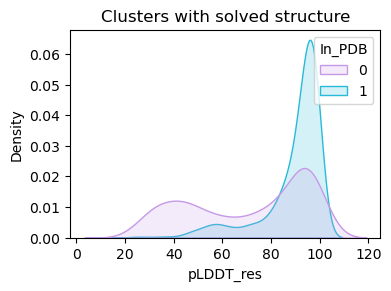

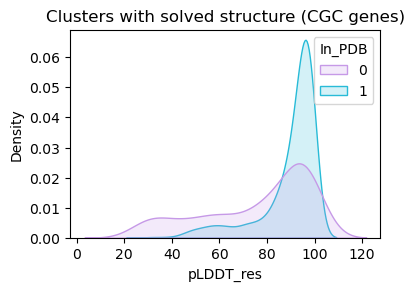

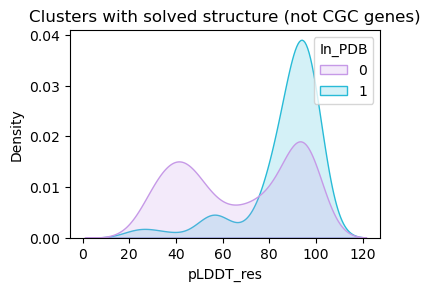

In [29]:
o3d_clusters_in_pdb = get_cluster_in_pdb(o3d_clusters, pdb_uniprot)

fig, ax = plt.subplots(figsize=(4, 2.7))    
lut = {1: '#28BBD7', 0: '#C699E7'}
sns.kdeplot(data=o3d_clusters_in_pdb, x='pLDDT_res', hue='In_PDB', fill=True, common_norm=False, palette=lut, alpha=0.2, legend=True)
plt.title("Clusters with solved structure")
plt.show()

fig, ax = plt.subplots(figsize=(4, 2.7))    
lut = {1: '#28BBD7', 0: '#C699E7'}
plt.title("Clusters with solved structure (CGC genes)")
sns.kdeplot(data=o3d_clusters_in_pdb[o3d_clusters_in_pdb["CGC"] == 1], x='pLDDT_res', hue='In_PDB', fill=True, common_norm=False, palette=lut, alpha=0.2, legend=True)
plt.show()

fig, ax = plt.subplots(figsize=(4, 2.7))    
lut = {1: '#28BBD7', 0: '#C699E7'}
plt.title("Clusters with solved structure (not CGC genes)")
sns.kdeplot(data=o3d_clusters_in_pdb[o3d_clusters_in_pdb["CGC"] == 0], x='pLDDT_res', hue='In_PDB', fill=True, common_norm=False, palette=lut, alpha=0.2, legend=True)
plt.show()

# Table of detected CGC not in PDB

In [30]:
cgc_genes_hits = genetable[genetable["CGC"] == 1].drop(columns=["CGC"]).drop_duplicates().reset_index(drop=True)
cgc_genes_hits

,Gene,Uniprot_ID
0,PIK3CA,P42336
1,FGFR3,P22607
2,FBXW7,Q969H0
3,TP53,P04637
4,BRAF,P15056
...,...,...
101,KAT6A,Q92794
102,RHOA,P61586
103,CNBD1,Q8NA66
104,CDH1,P12830


In [31]:
pdb_uniprot_api = pdb_uniprot_api[pdb_uniprot_api.Uniprot_ID.isin(cgc_genes_hits.Uniprot_ID)]
pdb_uniprot_api['Max_Coverage'] = pdb_uniprot_api.groupby('Uniprot_ID')['Coverage'].transform('max').reset_index(drop=True).values
pdb_uniprot_api

/tmp/ipykernel_3188128/733075023.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pdb_uniprot_api['Max_Coverage'] = pdb_uniprot_api.groupby('Uniprot_ID')['Coverage'].transform('max').reset_index(drop=True).values


,Gene,CGC,Uniprot_ID,PDB,Start,End,Resolution,Coverage,Max_Coverage
0,PIK3CA,1,P42336,2ENQ,331.0,481.0,NaN,14.14,100.00
1,PIK3CA,1,P42336,2RD0,1.0,1068.0,3.05,100.00,100.00
2,PIK3CA,1,P42336,3HHM,1.0,1068.0,2.80,100.00,100.00
3,PIK3CA,1,P42336,3HIZ,1.0,1068.0,3.30,100.00,100.00
4,PIK3CA,1,P42336,3ZIM,107.0,1046.0,2.85,88.01,100.00
...,...,...,...,...,...,...,...,...,...
6216,EPAS1,1,Q99814,8CK8,239.0,350.0,2.30,12.87,12.87
6217,EPAS1,1,Q99814,8Q5S,523.0,542.0,1.49,2.30,12.87
6218,EPAS1,1,Q99814,8Q64,523.0,542.0,1.36,2.30,12.87
6219,EPAS1,1,Q99814,8Q6D,523.0,542.0,1.40,2.30,12.87


In [32]:
cgc_genes_hits = cgc_genes_hits.merge(pdb_uniprot_api[["Gene", "Uniprot_ID", "Max_Coverage"]].drop_duplicates(), on=["Gene", "Uniprot_ID"], how="left")
cgc_genes_hits

,Gene,Uniprot_ID,Max_Coverage
0,PIK3CA,P42336,100.00
1,FGFR3,P22607,41.32
2,FBXW7,Q969H0,62.94
3,TP53,P04637,100.00
4,BRAF,P15056,100.00
...,...,...,...
101,KAT6A,Q92794,14.17
102,RHOA,P61586,100.00
103,CNBD1,Q8NA66,NaN
104,CDH1,P12830,61.68


In [33]:
cgc_genes_hits["Any"] = cgc_genes_hits.Gene.isin(pdb_uniprot_api.Gene)
cgc_genes_hits["Å < 3.5"] = cgc_genes_hits.Gene.isin(pdb_uniprot_api[pdb_uniprot_api["Resolution"] < 3.5].Gene)
cgc_genes_hits["Å < 2.5"] = cgc_genes_hits.Gene.isin(pdb_uniprot_api[pdb_uniprot_api["Resolution"] < 2.5].Gene)
cgc_genes_hits["Å < 1.5"] = cgc_genes_hits.Gene.isin(pdb_uniprot_api[pdb_uniprot_api["Resolution"] < 1.5].Gene)
cgc_genes_hits

,Gene,Uniprot_ID,Max_Coverage,Any,Å < 3.5,Å < 2.5,Å < 1.5
0,PIK3CA,P42336,100.00,True,True,True,False
1,FGFR3,P22607,41.32,True,True,True,False
2,FBXW7,Q969H0,62.94,True,True,False,False
3,TP53,P04637,100.00,True,True,True,True
4,BRAF,P15056,100.00,True,True,True,False
...,...,...,...,...,...,...,...
101,KAT6A,Q92794,14.17,True,True,True,True
102,RHOA,P61586,100.00,True,True,True,True
103,CNBD1,Q8NA66,NaN,False,False,False,False
104,CDH1,P12830,61.68,True,True,True,False


In [34]:
genetable_order = pd.read_table(f"{WORKSPACE}/projects/clustering_3d/o3d_analysys/o3d_paper/notebooks/0.genetables/results/{SUBDIR}/{RUN}.genetable.tsv")
genetable_order = genetable_order[["Gene", "CGC", "Fish", "o3d_qval"]]
genetable_order = genetable_order[(genetable_order["o3d_qval"] < 0.01) & (genetable_order["CGC"] == 1)].reset_index(drop=True)
genetable_order = genetable_order.Gene.value_counts().reset_index().rename(columns={"Gene": "Count", "index": "Gene"})
genetable_order

,Gene,Count
0,TP53,66
1,PIK3CA,35
2,KRAS,33
3,CTNNB1,19
4,BRAF,18
...,...,...
101,STAT6,1
102,DNMT3A,1
103,SRSF2,1
104,BCLAF1,1


In [35]:
cgc_genes_hits = genetable_order.merge(cgc_genes_hits, on="Gene", how="inner")
cgc_genes_hits[:60]

,Gene,Count,Uniprot_ID,Max_Coverage,Any,Å < 3.5,Å < 2.5,Å < 1.5
0,TP53,66,P04637,100.00,True,True,True,True
1,PIK3CA,35,P42336,100.00,True,True,True,False
2,KRAS,33,P01116,100.00,True,True,True,True
3,CTNNB1,19,P35222,82.46,True,True,True,False
4,BRAF,18,P15056,100.00,True,True,True,False
5,NRAS,16,P01111,91.01,True,True,True,True
6,NFE2L2,10,Q16236,18.02,True,True,True,False
7,SMAD4,10,Q13485,48.55,True,True,True,False
8,SPOP,10,O43791,100.00,True,True,True,True
9,SF3B1,9,O75533,100.00,True,True,True,False


In [36]:
cgc_genes_hits.to_csv("data/genes_detected_in_pdb.tsv", sep="\t", index=False)